In [11]:
import librosa 
import librosa.display
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tensorflow import keras 
from tensorflow.keras.preprocessing import image_dataset_from_directory, image 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint





In [16]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [3]:
path = Path.cwd()/'data'
answers = pd.read_csv('answers.csv')
images_directory = path/'train_images'

In [21]:
cb_training = image_dataset_from_directory(images_directory, labels='inferred', image_size=(97,97), subset='training', validation_split=.2, seed=10)
cb_validation = image_dataset_from_directory(images_directory, labels='inferred', image_size=(97,97), subset='validation', validation_split=.2, seed=10)

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.


In [27]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(97,97, 3)))
cnn.add(Conv2D(filters=5, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=40, kernel_size=3, activation='relu', padding='same'))
cnn.add(GlobalAveragePooling2D())

cnn.add(layers.Dense(100, activation='relu'))
cnn.add(Dropout(.5))
cnn.add(layers.Dense(100, activation='relu'))
cnn.add(Dropout(.5))

cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 97, 97, 5)         140       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 48, 48, 5)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 48, 48, 10)        460       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 24, 24, 10)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 24, 24, 20)        1820      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 12, 12, 30)       

In [23]:
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
checkpoint = ModelCheckpoint('simple_cnn.h5', monitor='val_loss', verbose=1,save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)

In [28]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)


In [29]:
xx =compute_class_weight(class_weight='balanced',classes=np.unique(answers.label), y=answers.label)
class_weight = dict(zip(np.unique(answers.label), xx))

In [33]:
history = cnn.fit(cb_training, epochs=40,validation_data=cb_validation, class_weight = class_weight, callbacks=[earlystop])

Epoch 1/40
750/750 [==============================] - 72s 96ms/step - loss: 0.2891 - tp: 5298.0000 - fp: 3199.0000 - tn: 15173.0000 - fn: 330.0000 - accuracy: 0.8530 - precision: 0.6235 - recall: 0.9414 - auc: 0.9416 - prc: 0.7976 - val_loss: 0.3515 - val_tp: 1378.0000 - val_fp: 872.0000 - val_tn: 3729.0000 - val_fn: 21.0000 - val_accuracy: 0.8512 - val_precision: 0.6124 - val_recall: 0.9850 - val_auc: 0.9598 - val_prc: 0.8524


# Short Analysis 
So these are consistenly a little lower than the notebook 3 - we did change the spectrograms, and maybe we shouldnt have? 
Lets fix this. 

In [35]:
def read_sound(index, df, feature=True):
    row = df.iloc[index]
    clip_path = row['clip_path']
    if feature:
        image_path = row['image_path']
    else:
        image_path = row['image_path2']
    y, sr = librosa.load(clip_path, sr=None)
    del clip_path, row
    return y, sr, image_path, feature 

def create_spectrogram(input_tuple):
    y, sr, output_file,feature = input_tuple
    n_fft=192
    
    fig = plt.figure(figsize=[1, 1])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    if feature:
        spec = librosa.feature.melspectrogram(y=y, sr=sr)
    else:
        spec = librosa.stft(y, n_fft=n_fft)
    librosa.display.specshow(librosa.power_to_db(spec, ref=np.min),n_fft=n_fft)
    plt.savefig(output_file, dpi=97, bbox_inches='tight', pad_inches=0)
    plt.close()
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del spec, fig, ax, y, sr, output_file, input_tuple
    

In [37]:
from tqdm import tqdm

for i in tqdm(range(0, answers.shape[0])):
    create_spectrogram(read_sound(i, answers,False))



100%|███████████████████████████████████| 30000/30000 [1:19:44<00:00,  6.27it/s]


In [38]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(97,97, 3)))
cnn.add(Conv2D(filters=5, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=40, kernel_size=3, activation='relu', padding='same'))
cnn.add(GlobalAveragePooling2D())

cnn.add(layers.Dense(100, activation='relu'))
cnn.add(Dropout(.5))
cnn.add(layers.Dense(100, activation='relu'))
cnn.add(Dropout(.5))

cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.summary()



earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
checkpoint = ModelCheckpoint('simple_cnn.h5', monitor='val_loss', verbose=1,save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)



METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

xx =compute_class_weight(class_weight='balanced',classes=np.unique(answers.label), y=answers.label)
class_weight = dict(zip(np.unique(answers.label), xx))


history = cnn.fit(cb_training, epochs=40,validation_data=cb_validation, class_weight = class_weight)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 97, 97, 5)         140       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 48, 48, 5)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 48, 48, 10)        460       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 24, 24, 10)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 24, 24, 20)        1820      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 12, 12, 30)       

Epoch 15/40
750/750 [==============================] - 81s 109ms/step - loss: 0.2000 - tp: 5374.0000 - fp: 2144.0000 - tn: 16228.0000 - fn: 254.0000 - accuracy: 0.9001 - precision: 0.7148 - recall: 0.9549 - auc: 0.9715 - prc: 0.8968 - val_loss: 0.2464 - val_tp: 1288.0000 - val_fp: 568.0000 - val_tn: 4033.0000 - val_fn: 111.0000 - val_accuracy: 0.8868 - val_precision: 0.6940 - val_recall: 0.9207 - val_auc: 0.9632 - val_prc: 0.8812
Epoch 16/40
750/750 [==============================] - 80s 107ms/step - loss: 0.1972 - tp: 5378.0000 - fp: 2098.0000 - tn: 16274.0000 - fn: 250.0000 - accuracy: 0.9022 - precision: 0.7194 - recall: 0.9556 - auc: 0.9725 - prc: 0.9001 - val_loss: 0.2626 - val_tp: 1315.0000 - val_fp: 634.0000 - val_tn: 3967.0000 - val_fn: 84.0000 - val_accuracy: 0.8803 - val_precision: 0.6747 - val_recall: 0.9400 - val_auc: 0.9626 - val_prc: 0.8763
Epoch 17/40
750/750 [==============================] - 81s 107ms/step - loss: 0.1920 - tp: 5391.0000 - fp: 2076.0000 - tn: 16296.0000

Epoch 34/40
750/750 [==============================] - 81s 108ms/step - loss: 0.1496 - tp: 5502.0000 - fp: 1705.0000 - tn: 16667.0000 - fn: 126.0000 - accuracy: 0.9237 - precision: 0.7634 - recall: 0.9776 - auc: 0.9823 - prc: 0.9317 - val_loss: 0.2993 - val_tp: 1243.0000 - val_fp: 442.0000 - val_tn: 4159.0000 - val_fn: 156.0000 - val_accuracy: 0.9003 - val_precision: 0.7377 - val_recall: 0.8885 - val_auc: 0.9520 - val_prc: 0.8649
Epoch 35/40
750/750 [==============================] - 81s 108ms/step - loss: 0.1490 - tp: 5484.0000 - fp: 1726.0000 - tn: 16646.0000 - fn: 144.0000 - accuracy: 0.9221 - precision: 0.7606 - recall: 0.9744 - auc: 0.9827 - prc: 0.9357 - val_loss: 0.3131 - val_tp: 1264.0000 - val_fp: 524.0000 - val_tn: 4077.0000 - val_fn: 135.0000 - val_accuracy: 0.8902 - val_precision: 0.7069 - val_recall: 0.9035 - val_auc: 0.9519 - val_prc: 0.8589
Epoch 36/40
750/750 [==============================] - 81s 107ms/step - loss: 0.1511 - tp: 5486.0000 - fp: 1724.0000 - tn: 16648.000

In [44]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(97,97, 3)))
cnn.add(Conv2D(filters=5, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=40, kernel_size=3, activation='relu', padding='same'))
cnn.add(GlobalAveragePooling2D())

cnn.add(layers.Dense(1000, activation='relu'))
cnn.add(Dropout(.5))
cnn.add(layers.Dense(1000, activation='relu'))
cnn.add(Dropout(.5))

cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.summary()



earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
checkpoint = ModelCheckpoint('simple_cnn.h5', monitor='val_loss', verbose=1,save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)



METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

xx =compute_class_weight(class_weight='balanced',classes=np.unique(answers.label), y=answers.label)
class_weight = dict(zip(np.unique(answers.label), xx))


history = cnn.fit(cb_training, epochs=10,validation_data=cb_validation, class_weight = class_weight)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 97, 97, 5)         140       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 48, 48, 5)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 48, 48, 10)        460       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 24, 24, 10)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 24, 24, 20)        1820      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 12, 12, 30)       

# Analysis 
Much better with the new spectrograms. Lets try transfer learnign again in the next notebook 

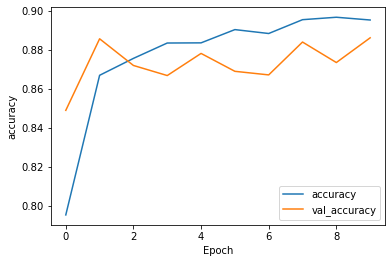

In [45]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#Recall is getting worse continuously. 

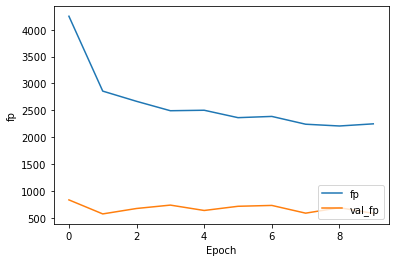

In [46]:
plt.plot(history.history['fp'], label='fp')
plt.plot(history.history['val_fp'], label = 'val_fp')
plt.xlabel('Epoch')
plt.ylabel('fp')
plt.legend(loc='lower right')
#False positive is getting a bit lower, but not as quickly as the test test - that makes sense -
#There are fewer entries in validation. 
#Lets check precision

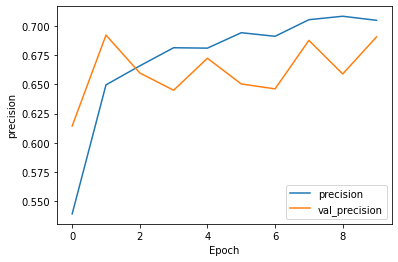

In [47]:
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label = 'val_precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend(loc='lower right')
#Precision is staying pretty constant for validation. 


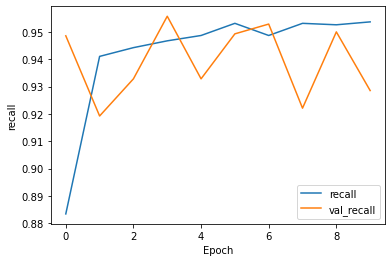

In [48]:
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.legend(loc='lower right')
#Precision is staying pretty constant for validation. 



# Analysis 
## Overfitting
Is better than it was. I like that. The recall for validation isnt dropping like a rock and neither is precision. 

## Precision
The precision is rather low, I will investigate why that is. 

## Sharp spikes 
Why do the spikes happen? 
